In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
df = pd.read_csv("yield_df.csv", index_col=0)
df.head()

Area         Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  \
0  Albania        Maize  1990        36613                         1485.0   
1  Albania     Potatoes  1990        66667                         1485.0   
2  Albania  Rice, paddy  1990        23333                         1485.0   
3  Albania      Sorghum  1990        12500                         1485.0   
4  Albania     Soybeans  1990         7000                         1485.0   

   pesticides_tonnes  avg_temp  
0              121.0     16.37  
1              121.0     16.37  
2              121.0     16.37  
3              121.0     16.37  
4              121.0     16.37

In [57]:
import numpy as np

# Apply log transformation to yield to reduce skewness
df["log_yield"] = np.log1p(df["hg/ha_yield"])  # log(1 + x) avoids log(0) issues

# Check distribution
print(df[["hg/ha_yield", "log_yield"]].describe())


         hg/ha_yield     log_yield
count   28242.000000  28242.000000
mean    77053.332094     10.682922
std     84956.612897      1.109011
min        50.000000      3.931826
25%     19919.250000      9.899492
50%     38295.000000     10.553101
75%    104676.750000     11.558642
max    501412.000000     13.125185


In [58]:
from sklearn.preprocessing import StandardScaler

# Select climate features & transformed yield
features_to_scale = ["log_yield", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]

# Initialize the scaler
scaler = StandardScaler()

# Scale features
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Check scaled data
print(df_scaled[features_to_scale].describe())


          log_yield  average_rain_fall_mm_per_year  pesticides_tonnes  \
count  2.824200e+04                   2.824200e+04       2.824200e+04   
mean  -3.079471e-16                   1.449163e-16       1.408908e-16   
std    1.000018e+00                   1.000018e+00       1.000018e+00   
min   -6.087601e+00                  -1.546994e+00      -6.183835e-01   
25%   -7.064344e-01                  -7.833986e-01      -5.899975e-01   
50%   -1.170621e-01                  -9.306286e-02      -3.260209e-01   
75%    7.896547e-01                   7.311134e-01       1.936526e-01   
max    2.202239e+00                   2.945823e+00       5.515571e+00   

           avg_temp  
count  2.824200e+04  
mean   4.750034e-16  
std    1.000018e+00  
min   -3.048608e+00  
25%   -6.083909e-01  
50%    1.532609e-01  
75%    8.646112e-01  
max    1.601310e+00  


In [59]:
# Compute average temp & rainfall per country per year (as a proxy for seasons)
df_clustering = df_scaled.groupby(["Area", "Year"])[["avg_temp", "average_rain_fall_mm_per_year"]].mean().reset_index()

# Pivot the dataset: Each row = Country, Columns = avg_temp & rainfall for each year
df_pivot = df_clustering.pivot(index="Area", columns="Year", values=["avg_temp", "average_rain_fall_mm_per_year"])

# Flatten multi-level columns for readability
df_pivot.columns = [f"{col[0]}_Season_{col[1]}" for col in df_pivot.columns]
df_pivot.reset_index(inplace=True)

# Check the transformed dataset
print(df_pivot.head())

# Compute the country's average temperature & rainfall (ignoring seasons)
df_country_avg = df_clustering.groupby("Area")[["avg_temp", "average_rain_fall_mm_per_year"]].mean()

# Iterate through pivoted columns and fill NaNs with the country's overall climate average
for col in df_pivot.columns:
    if "avg_temp" in col:
        df_pivot[col] = df_pivot[col].fillna(df_pivot["Area"].map(df_country_avg["avg_temp"]))
    elif "average_rain_fall_mm_per_year" in col:
        df_pivot[col] = df_pivot[col].fillna(df_pivot["Area"].map(df_country_avg["average_rain_fall_mm_per_year"]))

# Check final dataset
print(df_pivot.isnull().sum().sum())  # Ensure all NaNs are filled
df_pivot

        Area  avg_temp_Season_1990  avg_temp_Season_1991  \
0    Albania             -0.661069             -0.821083   
1    Algeria             -0.485212             -0.678496   
2     Angola              0.566763              0.550920   
3  Argentina             -0.471745             -0.442436   
4    Armenia                   NaN                   NaN   

   avg_temp_Season_1992  avg_temp_Season_1993  avg_temp_Season_1994  \
0             -0.710182             -0.711766             -0.567595   
1             -0.676912             -0.561258             -0.421840   
2              0.541414              0.571516              0.554089   
3             -0.513729             -0.493925             -0.364805   
4             -2.075848             -2.036241             -1.854046   

   avg_temp_Season_1995  avg_temp_Season_1996  avg_temp_Season_1997  \
0             -0.771970             -0.776723             -0.735531   
1             -0.504223             -0.599281             -0.428177   

Area  avg_temp_Season_1990  avg_temp_Season_1991  \
0           Albania             -0.661069             -0.821083   
1           Algeria             -0.485212             -0.678496   
2            Angola              0.566763              0.550920   
3         Argentina             -0.471745             -0.442436   
4           Armenia             -1.736657             -1.736657   
..              ...                   ...                   ...   
96          Ukraine             -1.921643             -1.921643   
97   United Kingdom             -1.670901             -1.820776   
98          Uruguay             -0.575517             -0.569180   
99           Zambia              0.140586              0.047113   
100        Zimbabwe              0.102563              0.064540   

     avg_temp_Season_1992  avg_temp_Season_1993  avg_temp_Season_1994  \
0               -0.710182             -0.711766             -0.567595   
1               -0.676912             -0.561258             -0.421840   
2                0.541414              0.571516              0.554089   
3               -0.513729             -0.493925             -0.364805   
4               -2.075848             -2.036241             -1.854046   
..                    ...                   ...                   ...   
96              -1.976037             -2.162985             -1.990296   
97              -1.784654             -1.850561             -1.756453   
98              -0.608787             -0.591360             -0.534325   
99               0.207127              0.072462              0.104148   
100              0.219801              0.053450              0.015427   

     avg_temp_Season_1995  avg_temp_Season_1996  avg_temp_Season_1997  \
0               -0.771970             -0.776723             -0.735531   
1               -0.504223             -0.599281             -0.428177   
2                0.636472              0.565179              0.557257   
3               -0.453526             -0.433722             -0.337080   
4               -1.708291             -1.741561             -1.812854   
..                    ...                   ...                   ...   
96              -1.945936             -2.145557             -2.112287   
97              -1.705122             -1.875593             -1.676922   
98              -0.615124             -0.556505             -0.488380   
99               0.208711              0.102563              0.056619   
100              0.162767              0.024933              0.013843   

     avg_temp_Season_1998  ...  average_rain_fall_mm_per_year_Season_2004  \
0               -0.676912  ...                                   0.473294   
1               -0.539078  ...                                  -1.493458   
2                0.699844  ...                                  -0.195909   
3               -0.501847  ...                                  -0.786216   
4               -1.625907  ...                                  -0.827073   
..                    ...  ...                                        ...   
96              -2.028319  ...                                  -0.822846   
97              -1.716212  ...                                   0.099949   
98              -0.597697  ...                                   0.212657   
99               0.123159  ...                                  -0.181820   
100              0.119991  ...                                  -0.693232   

     average_rain_fall_mm_per_year_Season_2005  \
0                                     0.473294   
1                                    -1.493458   
2                                    -0.195909   
3                                    -0.786216   
4                                    -0.827073   
..                                         ...   
96                                   -0.822846   
97                                    0.099949   
98                                    0.212657   
99                             

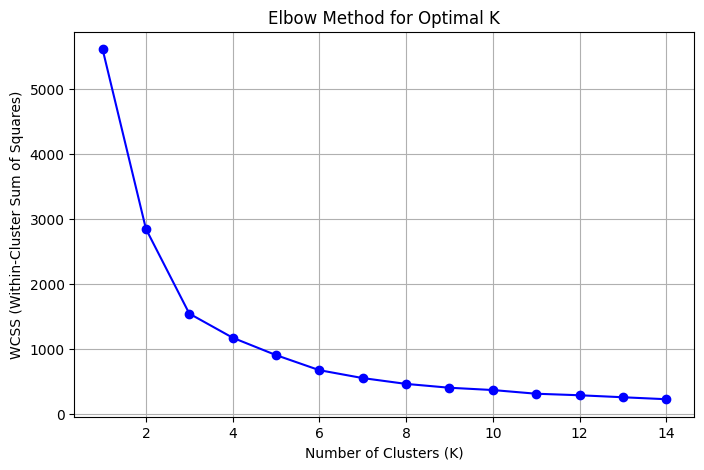

In [60]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select only the numerical seasonal features (excluding "Area")
X = df_pivot.drop(columns=["Area"])

# Test different values of K
wcss = []  # Store Within-Cluster Sum of Squares

K_range = range(1, 15)  # Try K values from 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

[0.43245454715448645]
[0.43245454715448645, 0.45942520618277727]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804, 0.4341832147634424]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804, 0.4341832147634424, 0.469062555996259]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804, 0.4341832147634424, 0.469062555996259, 0.4522340090979755]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804, 0.4341832147634424, 0.469062555996259, 0.4522340090979755, 0.4237946985013606]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804, 0.4341832147634424, 0.469062555996259, 0.4522340090979755, 0.4237946985013606, 0.4124859444732222]
[0.43245454715448645, 0.45942520618277727, 0.42866474794804, 0.4341832147634424, 0.469062555996259, 0.4522340090979755, 0.4237946985013606, 0.4124859444732222, 0.3875115964714014]


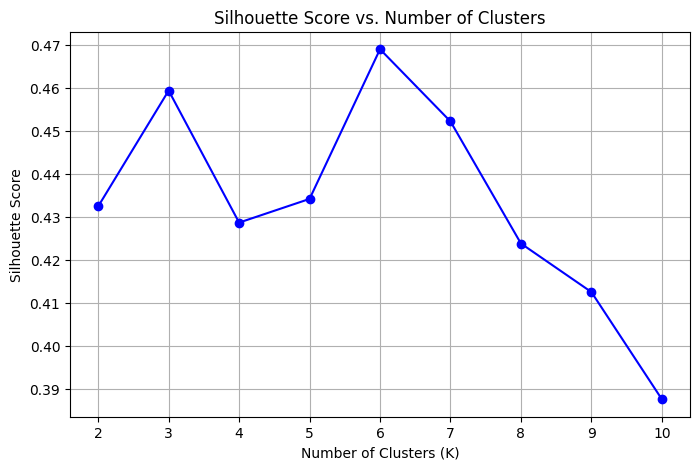

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different cluster values
K_range = range(2, 11)
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))
    print(silhouette_scores)
# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

In [62]:
from sklearn.cluster import KMeans

# Set number of clusters (adjust based on Elbow Method)
optimal_k = 3 

# Fit K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pivot["Cluster"] = kmeans.fit_predict(df_pivot.drop(columns=["Area"]))
df_pivot = df_pivot.drop_duplicates(subset=['Area'])

# Merge clusters back to the main dataset
df_merged = df_scaled.merge(df_pivot[["Area", "Cluster"]], on="Area", how="left")

# Count the number of countries per cluster
cluster_counts = df_merged["Cluster"].value_counts().sort_index()
print(cluster_counts)

0     7932
1     6640
2    13670
Name: Cluster, dtype: int64


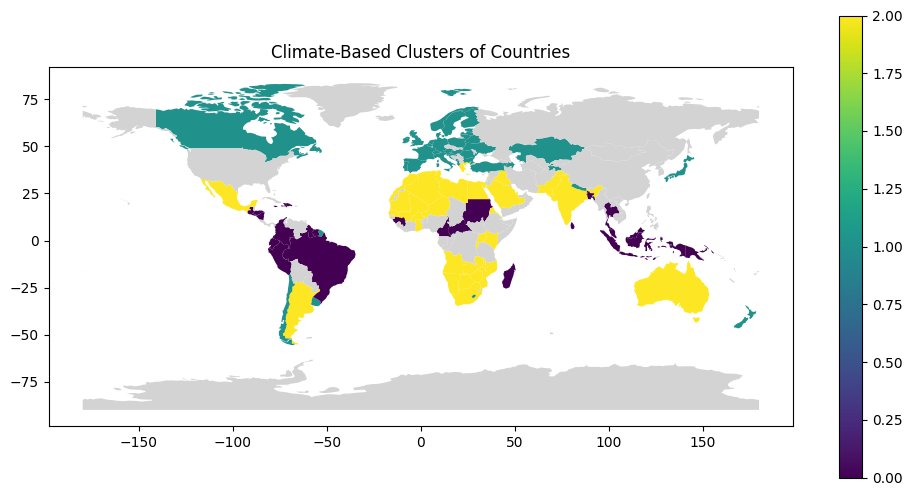

In [63]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the world map from Natural Earth (this is the correct method now)
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Merge with cluster data (ensure "Area" matches "name" in GeoPandas)
df_pivot_map = df_pivot[["Area", "Cluster"]]
df_pivot_map.columns = ["ADMIN", "Cluster"]

# Merge world map with cluster data
world = world.merge(df_pivot_map, on="ADMIN", how="left")

# Plot map with climate clusters
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
world.plot(column="Cluster", cmap="viridis", legend=True, ax=ax, missing_kwds={"color": "lightgrey"})

plt.title("Climate-Based Clusters of Countries")
plt.savefig("climate_based_clusters.png", dpi=300, bbox_inches="tight")

plt.show()

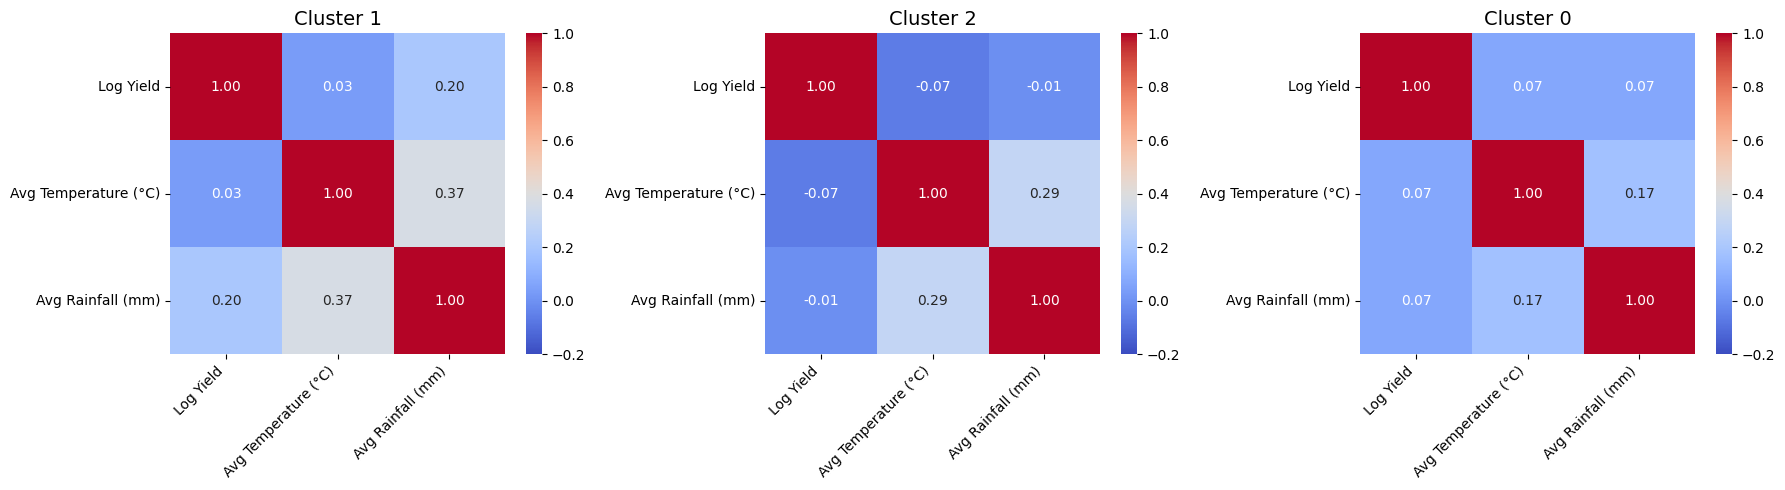

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary to clean up feature names
feature_names = {
    "log_yield": "Log Yield",
    "avg_temp": "Avg Temperature (°C)",
    "average_rain_fall_mm_per_year": "Avg Rainfall (mm)"
}

# Get unique clusters
unique_clusters = df_merged["Cluster"].unique()

# Create subplots (one row, three columns)
fig, axes = plt.subplots(1, len(unique_clusters), figsize=(6 * len(unique_clusters), 5))

# Ensure axes are iterable (if only one cluster exists)
if len(unique_clusters) == 1:
    axes = [axes]

# Loop through clusters and create heatmaps
for ax, cluster in zip(axes, unique_clusters):
    df_cluster = df_merged[df_merged["Cluster"] == cluster]

    # Compute correlation matrix
    correlation_matrix = df_cluster[["log_yield", "avg_temp", "average_rain_fall_mm_per_year"]].corr()

    # Rename columns and index for readability
    correlation_matrix.rename(columns=feature_names, index=feature_names, inplace=True)

    # Plot heatmap on respective subplot
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax, vmin=-0.2, vmax=1)

    # Formatting
    ax.set_title(f"Cluster {cluster}", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Adjust layout and display
plt.tight_layout()
plt.show()



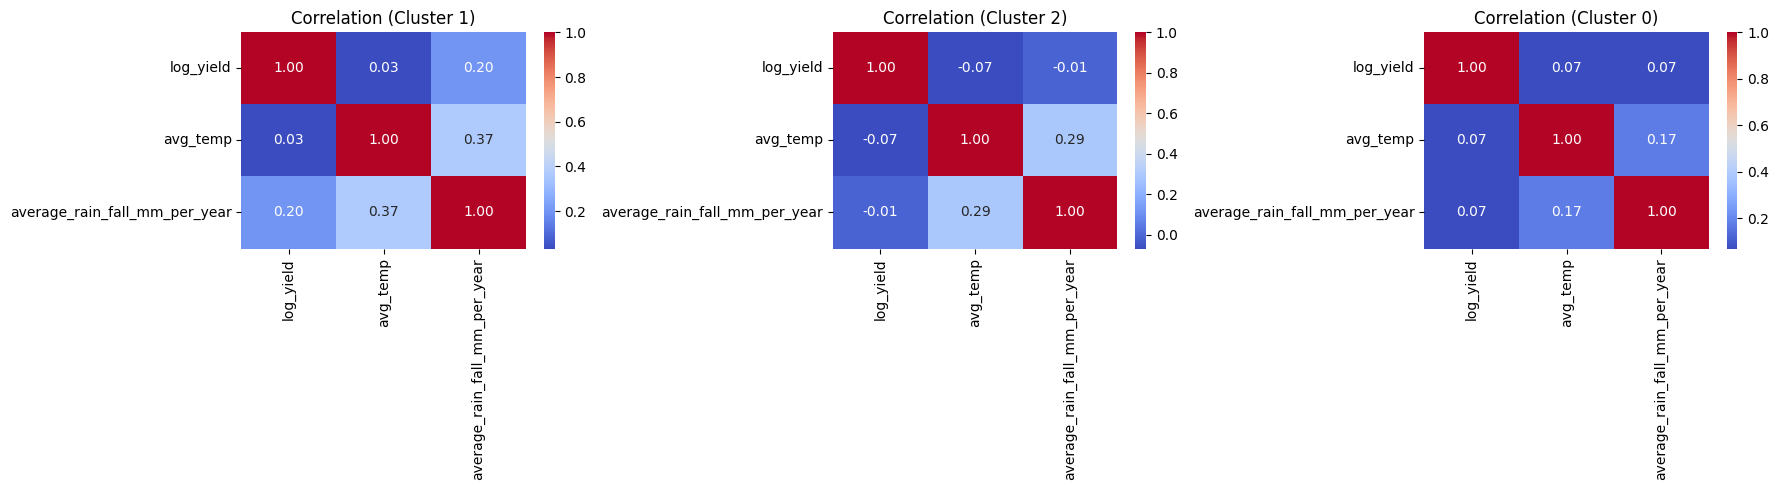

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique clusters
unique_clusters = df_merged["Cluster"].unique()

# Create a single figure with subplots
fig, axes = plt.subplots(1, len(unique_clusters), figsize=(6 * len(unique_clusters), 5))  # Adjust size dynamically

# Ensure axes is iterable when there's only one cluster
if len(unique_clusters) == 1:
    axes = [axes]

# Loop through clusters and create heatmaps
for ax, cluster in zip(axes, unique_clusters):
    df_cluster = df_merged[df_merged["Cluster"] == cluster]

    # Compute correlation matrix
    correlation_matrix = df_cluster[["log_yield", "avg_temp", "average_rain_fall_mm_per_year"]].corr()

    # Plot heatmap on respective subplot
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
    ax.set_title(f"Correlation (Cluster {cluster})")

# Adjust layout and display
plt.tight_layout()
plt.show()


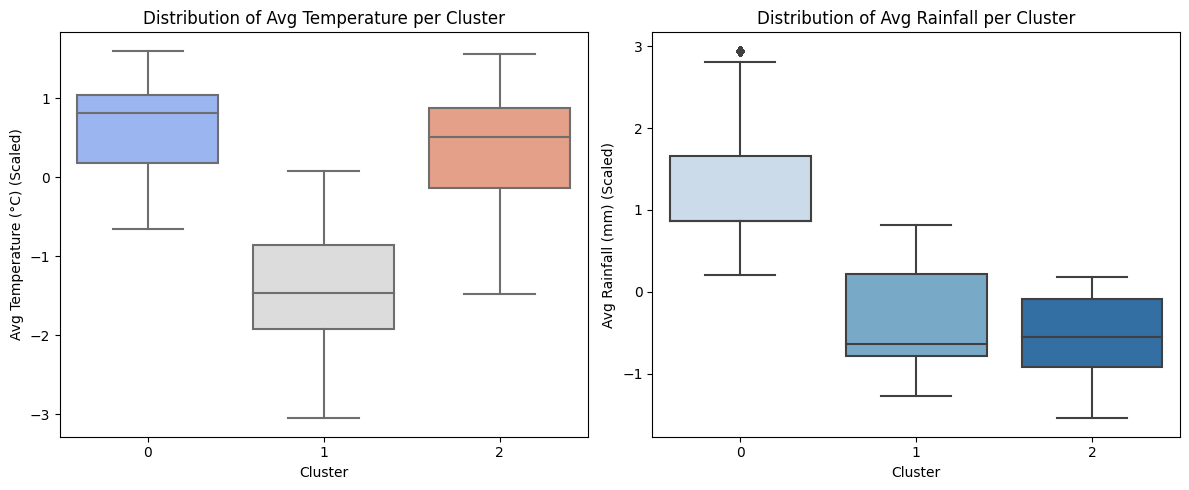

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for average temperature per cluster
sns.boxplot(data=df_merged, x="Cluster", y="avg_temp", palette="coolwarm", ax=axes[0])
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Avg Temperature (°C) (Scaled)")
axes[0].set_title("Distribution of Avg Temperature per Cluster")

# Boxplot for average rainfall per cluster
sns.boxplot(data=df_merged, x="Cluster", y="average_rain_fall_mm_per_year", palette="Blues", ax=axes[1])
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Avg Rainfall (mm) (Scaled)")
axes[1].set_title("Distribution of Avg Rainfall per Cluster")

# Adjust layout and display
plt.tight_layout()
plt.show()


In [29]:
# Compute correlation between temperature and crop yield per cluster and crop
correlation_results = df_merged.groupby(["Cluster", "Item"])[["log_yield", "avg_temp"]].corr().unstack().iloc[:, 1].reset_index()
correlation_results.columns = ["Cluster", "Item", "Correlation_with_Temp"]

# Display results
print(correlation_results.sort_values("Correlation_with_Temp", ascending=False))


    Cluster                  Item  Correlation_with_Temp
12        1           Rice, paddy               0.456912
18        2               Cassava               0.422493
27        2                  Yams               0.282633
13        1               Sorghum               0.274229
0         0               Cassava               0.268951
15        1        Sweet potatoes               0.261565
11        1              Potatoes               0.168244
26        2                 Wheat               0.151782
7         0        Sweet potatoes               0.075307
14        1              Soybeans               0.061316
3         0              Potatoes               0.027376
8         0                 Wheat               0.026699
4         0           Rice, paddy              -0.010624
9         0                  Yams              -0.042092
1         0                 Maize              -0.042584
2         0  Plantains and others              -0.087129
16        1                 Whe

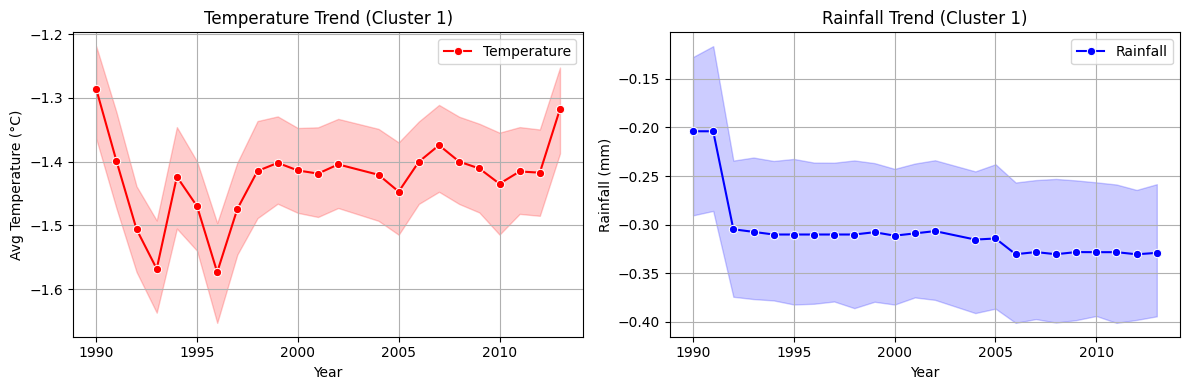

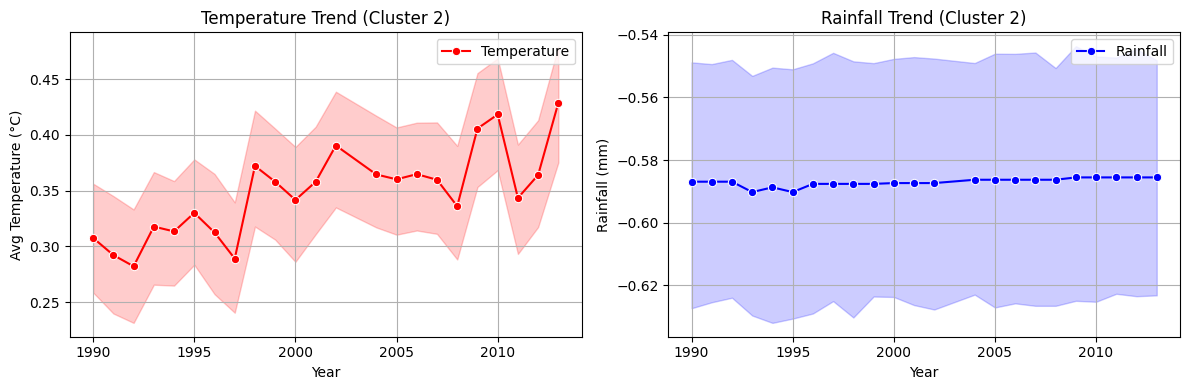

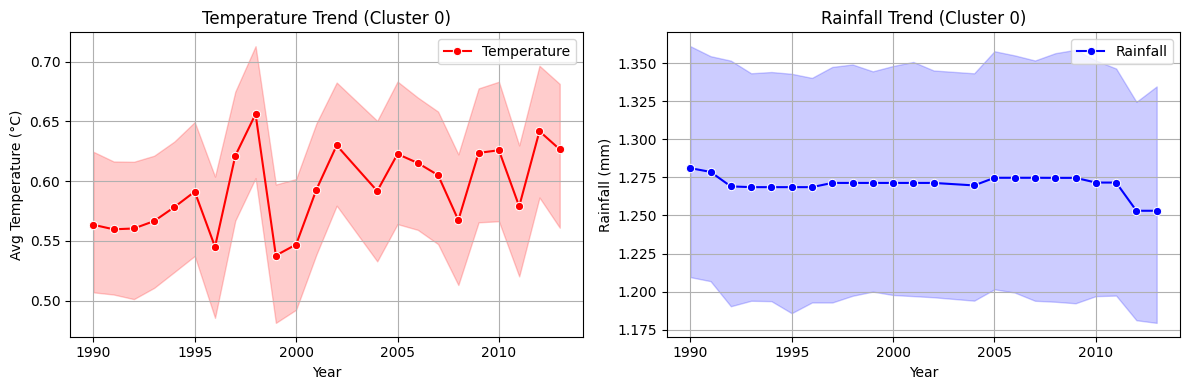

In [65]:
# Loop through clusters to plot temperature and rainfall trends
for cluster in df_merged["Cluster"].unique():
    df_cluster = df_merged[df_merged["Cluster"] == cluster]

    plt.figure(figsize=(12, 4))

    # Plot temperature trends
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df_cluster, x="Year", y="avg_temp", marker="o", label="Temperature", color="r")
    plt.xlabel("Year")
    plt.ylabel("Avg Temperature (°C)")
    plt.title(f"Temperature Trend (Cluster {cluster})")
    plt.grid(True)

    # Plot rainfall trends
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df_cluster, x="Year", y="average_rain_fall_mm_per_year", marker="o", label="Rainfall", color="b")
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.title(f"Rainfall Trend (Cluster {cluster})")
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [66]:
import pandas as pd

# Compute year-over-year (YoY) change in yield
df_merged["YoY_Change"] = df_merged.groupby(["Cluster", "Item"])["log_yield"].diff()

# Identify seasons with yield decline
df_decline = df_merged[df_merged["YoY_Change"] < 0]

# Display the first few rows of declining yield seasons
print(df_decline[["Area", "Cluster", "Item", "Year", "log_yield", "YoY_Change"]].head())


       Area  Cluster      Item  Year  log_yield  YoY_Change
6   Albania        1     Maize  1991  -0.365642   -0.208080
9   Albania        1   Sorghum  1991  -1.693292   -0.566721
10  Albania        1  Soybeans  1991  -1.778465   -0.129116
11  Albania        1     Wheat  1991  -0.671855   -0.340571
12  Albania        1     Maize  1992  -0.506066   -0.140424


In [67]:
# Count number of declining seasons per cluster
decline_counts = df_decline.groupby("Cluster")["Year"].count()

print(decline_counts)


Cluster
0    1782
1    1701
2    2297
Name: Year, dtype: int64


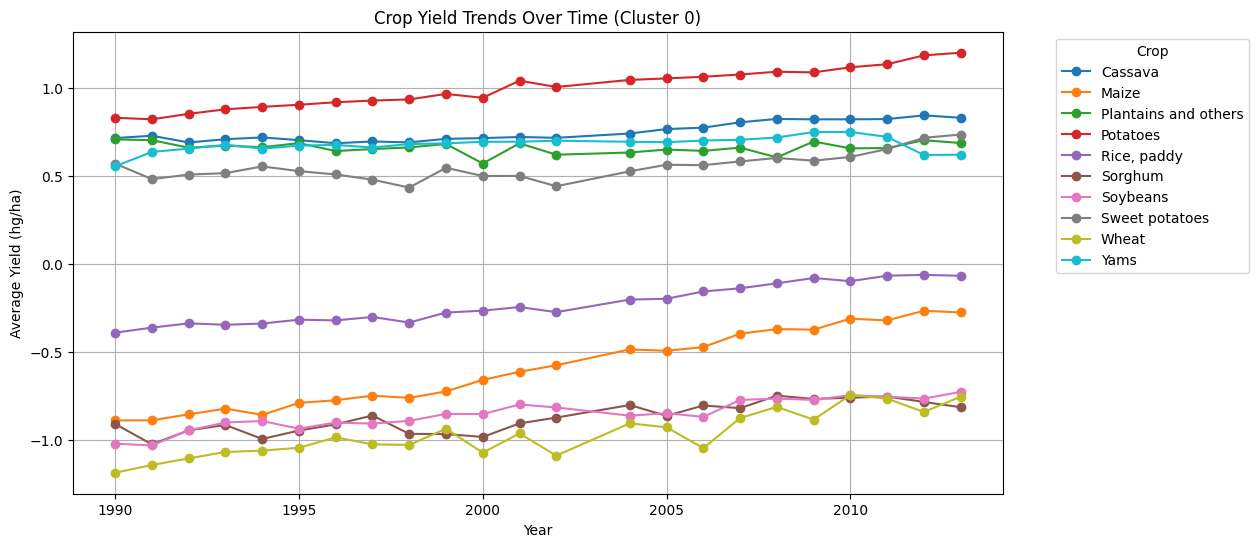

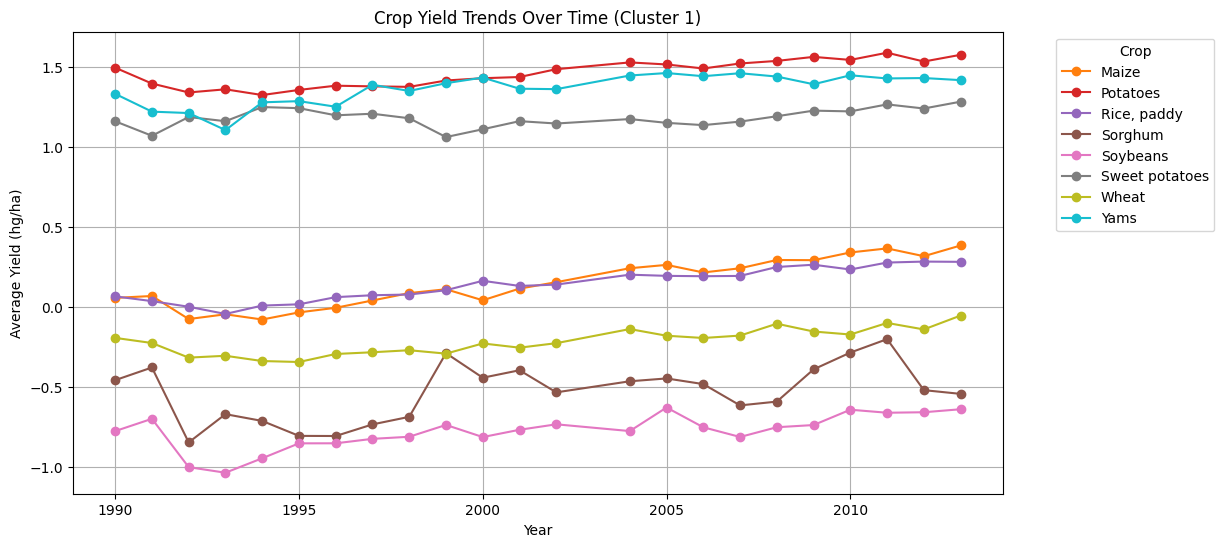

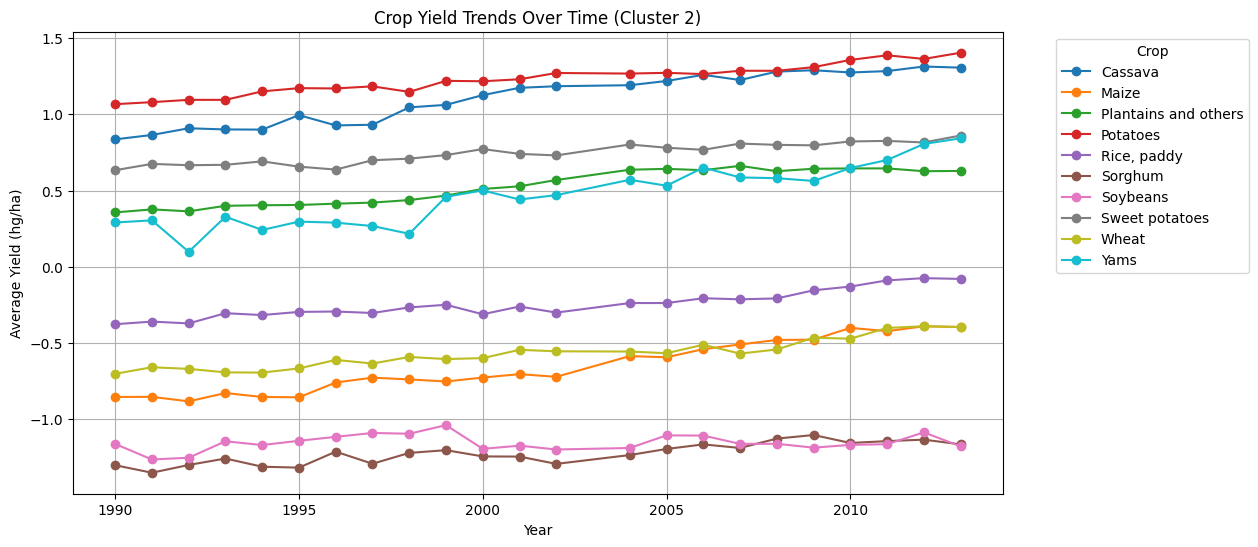

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute average yield per cluster per year per crop
df_avg_yield = df_merged.groupby(["Cluster", "Year", "Item"])["log_yield"].mean().reset_index()

# Get unique clusters and crops
unique_clusters = df_avg_yield["Cluster"].unique()
unique_crops = df_avg_yield["Item"].unique()

# Create a fixed color palette for crops
crop_colors = sns.color_palette("tab10", len(unique_crops))  # Generate colors
crop_color_map = dict(zip(unique_crops, crop_colors))  # Map each crop to a fixed color

# Loop through each cluster and plot yield trends with consistent colors
for cluster in unique_clusters:
    plt.figure(figsize=(12, 6))
    
    # Filter data for the current cluster
    df_cluster = df_avg_yield[df_avg_yield["Cluster"] == cluster]
    
    # Plot each crop's time series using fixed colors
    for crop in unique_crops:
        df_crop = df_cluster[df_cluster["Item"] == crop]
        if not df_crop.empty:  # Avoid errors if a crop is missing in a cluster
            plt.plot(df_crop["Year"], df_crop["log_yield"], marker="o", linestyle="-",
                     label=crop, color=crop_color_map[crop])  # Use fixed color

    # Formatting
    plt.xlabel("Year")
    plt.ylabel("Average Yield (hg/ha)")
    plt.title(f"Crop Yield Trends Over Time (Cluster {cluster})")
    plt.legend(title="Crop", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    
    # Show the plot for this cluster
    plt.show()
